In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = ""
from keras import layers
from keras.models import Model
from keras.layers import Input, Embedding, Dot, Add, Flatten
from keras.regularizers import l2
from keras.optimizers import SGD, Adam, rmsprop
from keras.layers import Dropout, Flatten, Conv1D
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
from keras.models import load_model
import numpy as np

################ 파일 로드
books = pd.read_csv('../data/BX-Books.csv', encoding='cp1252')
books = books.drop_duplicates(subset='ISBN')
users = pd.read_csv('../data/BX-users.csv', encoding='cp1252')
ratings = pd.read_csv('../data/BX-Book-Ratings.csv', encoding='cp1252')
ratings = ratings[ratings['Book-Rating']!=0].copy()

import keras.backend as KB
def RMSE(y_true, y_pred):
    return KB.sqrt(KB.mean((y_true - y_pred)**2))


def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+KB.epsilon()))
def recall_m(y_true, y_pred):
        true_positives = KB.sum(KB.round(KB.clip(y_true * y_pred, 0, 1)))
        possible_positives = KB.sum(KB.round(KB.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + KB.epsilon())
        return recall
def precision_m(y_true, y_pred):
        true_positives = KB.sum(KB.round(KB.clip(y_true * y_pred, 0, 1)))
        predicted_positives = KB.sum(KB.round(KB.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + KB.epsilon())
        return precision

################ 전처리
# 국가 추출
#print(users['Location'].apply(lambda x: x.split(',')[-1].strip()).unique())
users['Location'] = users['Location'].apply(lambda x: x.split(',')[-1].strip())
usa_list = ['usa', 'united state', 'united states', 'u.s.a.']
unknown_list = ['','far away...', 'here and there']
england_list = ['england','united kingdom']
spain_list = ['orense','spain']
# usa, unknown으로 처리
users['Location'] = users['Location'].replace(to_replace=usa_list, value='usa')
users['Location'] = users['Location'].replace(to_replace=unknown_list, value='unknown')

#england, spain 나라,도시 위치 오류 수정
users['Location'] = users['Location'].replace(to_replace=england_list, value='england')
users['Location'] = users['Location'].replace(to_replace=spain_list, value='spain')

# user, book, rating 테이블 병합
ratings = pd.merge(pd.merge(ratings, books, on='ISBN', how='left'), users, on='User-ID', how='left')
# Rating 0인 경우 제거
ratings = ratings[ratings['Book-Rating']!=0]
# 나이 최대 122세로 제한
ratings.loc[ratings['Age']>120, 'Age'] = 122

# 나이, 출판일자 범주형으로 변환
ratings['Age'] = ratings['Age'].apply(lambda x: str(int(x//10*10)))
ratings['Year-Of-Publication'] = ratings['Year-Of-Publication'].apply(lambda x: str(int(x//10*10)))

# 범주형 변수를 숫자로 변환
le = {}
cols = ['ISBN','Book-Author','Publisher','Year-Of-Publication','User-ID','Location','Age']
for col in cols:
    le[col] = LabelEncoder()
    ratings[col] = le[col].fit_transform(ratings[col].astype(str))

features = ['ISBN','Book-Author','Publisher','Year-Of-Publication','User-ID','Location','Age']
X_train, X_test, Y_train, Y_test = train_test_split(ratings[features], 
                                                    ratings['Book-Rating'].values, test_size=0.3, random_state=11)

mu = Y_train.mean()
batch_size = 16


Using TensorFlow backend.


# 학습 및 검증

W1208 22:04:25.644519 32668 deprecation_wrapper.py:119] From C:\Users\name\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1208 22:04:25.654961 32668 deprecation_wrapper.py:119] From C:\Users\name\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1208 22:04:25.657913 32668 deprecation_wrapper.py:119] From C:\Users\name\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1208 22:04:25.791819 32668 deprecation_wrapper.py:119] From C:\Users\name\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1208 22:04:25.878638 32668 deprecation.py:323] From C:\Users\name\Anaconda3\lib\sit

Train on 22378 samples, validate on 2487 samples
Epoch 1/100
22378/22378 [==============================] - 4s 185us/step - loss: 1.7383 - mean_squared_error: 3.1319 - RMSE: 1.7362 - val_loss: 1.7203 - val_mean_squared_error: 3.0531 - val_RMSE: 1.7173
Epoch 2/100
22378/22378 [==============================] - 4s 179us/step - loss: 1.6088 - mean_squared_error: 2.6835 - RMSE: 1.6041 - val_loss: 1.6930 - val_mean_squared_error: 2.9509 - val_RMSE: 1.6867
Epoch 3/100
22378/22378 [==============================] - 3s 155us/step - loss: 1.5222 - mean_squared_error: 2.3987 - RMSE: 1.5137 - val_loss: 1.6819 - val_mean_squared_error: 2.9010 - val_RMSE: 1.6714
Epoch 4/100
22378/22378 [==============================] - 3s 149us/step - loss: 1.4577 - mean_squared_error: 2.1850 - RMSE: 1.4447 - val_loss: 1.6767 - val_mean_squared_error: 2.8682 - val_RMSE: 1.6613
Epoch 5/100
22378/22378 [==============================] - 4s 156us/step - loss: 1.4031 - mean_squared_error: 2.0148 - RMSE: 1.3851 - val_l

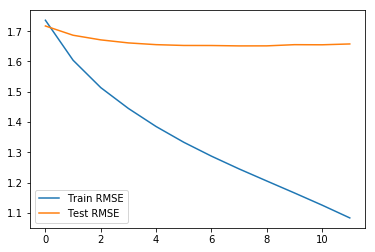

baseline:  1.825031785944131
rmse:  1.6398587645068416


In [2]:
################ 1. Matrix Factorization
import reco_models
features=['ISBN','User-ID']
f_size = [len(set(ratings[i])) for i in features] 

model = reco_models.factorization_machine(f_size, k_latent=5, embedding_reg=0.00001)

import keras.backend as KB
def RMSE(y_true, y_pred):
    return KB.sqrt(KB.mean((y_true - y_pred)**2))

model.compile(
  loss=RMSE,
  #optimizer=Adam(lr=0.0003),
  optimizer=SGD(lr=0.07, momentum=0.9),
  metrics=['mse', RMSE],
)

reduce_lr = ReduceLROnPlateau(monitor='val_RMSE', factor=0.2,  patience=5)
es = EarlyStopping(monitor='val_RMSE', patience=4, restore_best_weights=True)

result = model.fit(x=[X_train[feature].values for feature in features], y=(Y_train-mu),
                   batch_size=batch_size, epochs=100, 
                   validation_split=0.1,
                   callbacks=[reduce_lr, es])
# eval
# Plot RMSE
plt.plot(result.history['RMSE'], label="Train RMSE")
plt.plot(result.history['val_RMSE'], label="Test RMSE")
plt.legend()
plt.show()

import numpy as np
predictions = model.predict([X_test[feature].values for feature in features])+mu
print('baseline: ', np.mean((Y_test-np.mean(Y_test))**2)**0.5)
print('rmse: ', np.sqrt(np.mean((Y_test-predictions.reshape(-1,))**2)))
mf_pred = predictions


Train on 24865 samples, validate on 10657 samples
Epoch 1/100
24865/24865 [==============================] - 13s 537us/step - loss: 3.2852 - mean_squared_error: 3.2740 - RMSE: 1.7774 - val_loss: 3.1278 - val_mean_squared_error: 3.1186 - val_RMSE: 1.7367
Epoch 2/100
24865/24865 [==============================] - 14s 560us/step - loss: 2.8922 - mean_squared_error: 2.8736 - RMSE: 1.6625 - val_loss: 2.8152 - val_mean_squared_error: 2.7883 - val_RMSE: 1.6362
Epoch 3/100
24865/24865 [==============================] - 13s 538us/step - loss: 2.5056 - mean_squared_error: 2.4703 - RMSE: 1.5338 - val_loss: 2.7448 - val_mean_squared_error: 2.7031 - val_RMSE: 1.6088
Epoch 4/100
24865/24865 [==============================] - 13s 511us/step - loss: 2.3043 - mean_squared_error: 2.2545 - RMSE: 1.4633 - val_loss: 2.7384 - val_mean_squared_error: 2.6824 - val_RMSE: 1.6001
Epoch 5/100
24865/24865 [==============================] - 13s 509us/step - loss: 2.1569 - mean_squared_error: 2.0921 - RMSE: 1.4092 -

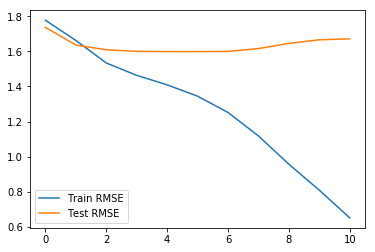

baseline:  1.8256998480931332
rmse:  1.6370445752256595


In [3]:
################ 2. Modified MF
import reco_models
features = ['ISBN','Book-Author','Publisher','Year-Of-Publication','User-ID','Location','Age']
model = reco_models.conv_mf(ratings, K=10, reg=0.0005)


model.compile(
  loss='mse',
  optimizer=Adam(lr=0.0003),
  #optimizer=SGD(lr=0.07, momentum=0.9),
  metrics=['mse', RMSE],
)

reduce_lr = ReduceLROnPlateau(monitor='val_RMSE', factor=0.2,  patience=5)
es = EarlyStopping(monitor='val_RMSE', patience=5, restore_best_weights=True)

result = model.fit(x=[X_train[feature].values for feature in features], y=(Y_train-mu),
                   batch_size=batch_size, epochs=100, 
                   validation_split=0.1,
                   callbacks=[reduce_lr, es])
# eval
# Plot RMSE
plt.plot(result.history['RMSE'], label="Train RMSE")
plt.plot(result.history['val_RMSE'], label="Test RMSE")
plt.legend()
plt.show()


predictions = model.predict([X_test[feature].values for feature in features]) + mu
print('baseline: ', np.mean((Y_test-mu)**2)**0.5)
print('rmse: ', np.sqrt(np.mean((Y_test-predictions.reshape(-1,))**2)))
conv_mf_pred = predictions


Train on 22378 samples, validate on 2487 samples
Epoch 1/100
22378/22378 [==============================] - 13s 575us/step - loss: 3.2911 - mean_squared_error: 3.2747 - RMSE: 1.7777 - val_loss: 3.2598 - val_mean_squared_error: 3.2467 - val_RMSE: 1.7725
Epoch 2/100
22378/22378 [==============================] - 11s 505us/step - loss: 3.0132 - mean_squared_error: 2.9884 - RMSE: 1.6939 - val_loss: 3.1384 - val_mean_squared_error: 3.1022 - val_RMSE: 1.7302
Epoch 3/100
22378/22378 [==============================] - 11s 501us/step - loss: 2.7070 - mean_squared_error: 2.6536 - RMSE: 1.5919 - val_loss: 3.0539 - val_mean_squared_error: 2.9846 - val_RMSE: 1.6948
Epoch 4/100
22378/22378 [==============================] - 11s 498us/step - loss: 2.4181 - mean_squared_error: 2.3295 - RMSE: 1.4887 - val_loss: 3.0059 - val_mean_squared_error: 2.8999 - val_RMSE: 1.6687
Epoch 5/100
22378/22378 [==============================] - 11s 494us/step - loss: 2.1620 - mean_squared_error: 2.0374 - RMSE: 1.3883 - 

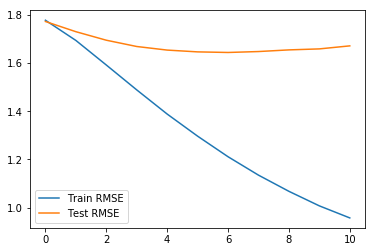

baseline:  1.825031785944131
rmse:  1.641353834576552


In [4]:
################ 3. Factorizaiton Machine
import reco_models
features = ['ISBN','Book-Author','Publisher','Year-Of-Publication','User-ID','Location','Age']
f_size = [len(set(ratings[i])) for i in features] 
import keras.backend as KB
def RMSE(y_true, y_pred):
    return KB.sqrt(KB.mean((y_true - y_pred)**2))

model=reco_models.factorization_machine(f_size, k_latent=10, embedding_reg=0.0005)
model.compile(
  loss='mse',
  optimizer=Adam(lr=0.0003),
  #optimizer=SGD(lr=0.07, momentum=0.9),
  metrics=['mse', RMSE],
)

reduce_lr = ReduceLROnPlateau(monitor='val_RMSE', factor=0.2,  patience=5)
es = EarlyStopping(monitor='val_RMSE', patience=4, restore_best_weights=True)

result = model.fit(x=[X_train[feature].values for feature in features], y=(Y_train-mu),
                   batch_size=batch_size, epochs=100, 
                   validation_split=0.1,
                   callbacks=[reduce_lr, es])

# eval
# Plot RMSE
plt.plot(result.history['RMSE'], label="Train RMSE")
plt.plot(result.history['val_RMSE'], label="Test RMSE")
plt.legend()
plt.show()

import numpy as np
predictions = model.predict([X_test[feature].values for feature in features]) + mu
print('baseline: ', np.mean((Y_test-np.mean(Y_test))**2)**0.5)
print('rmse: ', np.sqrt(np.mean((Y_test-predictions.reshape(-1,))**2)))
fm_pred = predictions



In [5]:
ensemble_pred = np.hstack([mf_pred, fm_pred, conv_mf_pred]).mean(axis=1) 
#ensemble_pred = np.hstack([fm_pred, mf_pred]).mean(axis=1) 

In [6]:
################ 4. Hybrid
predictions = ensemble_pred.clip(1,10)
print('baseline: ', np.mean((Y_test-np.mean(Y_test))**2)**0.5)
print('rmse: ', np.sqrt(np.mean((Y_test-predictions.reshape(-1,))**2)))

baseline:  1.825031785944131
rmse:  1.6132957130210686


In [8]:
################ 5. Hybrid + classification
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+KB.epsilon()))
def recall_m(y_true, y_pred):
        true_positives = KB.sum(KB.round(KB.clip(y_true * y_pred, 0, 1)))
        possible_positives = KB.sum(KB.round(KB.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + KB.epsilon())
        return recall
def precision_m(y_true, y_pred):
        true_positives = KB.sum(KB.round(KB.clip(y_true * y_pred, 0, 1)))
        predicted_positives = KB.sum(KB.round(KB.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + KB.epsilon())
        return precision

import classification
clf_model = load_model('../model/clf1209.h5', custom_objects={"f1_m":f1_m,"recall_m":recall_m,"precision_m":precision_m})

features = ['ISBN','Book-Author','Publisher','Year-Of-Publication','User-ID','Location','Age']
clf_pred = clf_model.predict([X_test[feature].values for feature in features])
clf_pred = (clf_pred>0.98).astype(float)*10
idx = np.where((clf_pred==10))[0]

predictions2 = predictions.copy()
predictions2[idx] = 10
print('baseline: ', np.mean((Y_test-mu)**2)**0.5)
print('rmse: ', np.sqrt(np.mean((Y_test-predictions2.reshape(-1,))**2)))

Train on 24865 samples, validate on 10657 samples
Epoch 1/100
24865/24865 [==============================] - 3s 110us/step - loss: 0.2348 - acc: 0.4750 - f1_m: 0.3579 - val_loss: 0.7009 - val_acc: 0.4617 - val_f1_m: 0.3926
Epoch 2/100
24865/24865 [==============================] - 2s 71us/step - loss: 0.2168 - acc: 0.5534 - f1_m: 0.3980 - val_loss: 0.6492 - val_acc: 0.6202 - val_f1_m: 0.4277
Epoch 3/100
24865/24865 [==============================] - 2s 72us/step - loss: 0.2068 - acc: 0.6596 - f1_m: 0.4572 - val_loss: 0.5991 - val_acc: 0.6920 - val_f1_m: 0.4760
Epoch 4/100
24865/24865 [==============================] - 2s 68us/step - loss: 0.1941 - acc: 0.7355 - f1_m: 0.5267 - val_loss: 0.5994 - val_acc: 0.6986 - val_f1_m: 0.4968
Epoch 5/100
24865/24865 [==============================] - 2s 68us/step - loss: 0.1840 - acc: 0.7632 - f1_m: 0.5669 - val_loss: 0.5956 - val_acc: 0.7030 - val_f1_m: 0.5038
Epoch 6/100
24865/24865 [==============================] - 2s 70us/step - loss: 0.1778 - 